Image Classification using pretrained model

In [9]:
from PIL import Image
import timm
import torch
from torchvision import transforms

img = Image.open(
'/home/plankton/Desktop/20220512-00120347_003.127bar_28.24C_44.jpg'
).convert('RGB')

model = timm.create_model('vit_large_patch14_clip_224.openai_ft_in12k_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
#data_config = {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.48145466, 0.4578275, 0.40821073), 'std': (0.26862954, 0.26130258, 0.27577711), 'crop_pct': 1.0, 'crop_mode': 'center'}
#transform = transforms.Compose([
#    transforms.Resize(size=224, max_size=None, antialias=None),
#    transforms.CenterCrop(size=(224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
#    #transforms.Normalize(mean=tensor([0.4815, 0.4578, 0.4082]), std=tensor([0.2686, 0.2613, 0.2758]))
#])
#print(transform)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
#trans = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)

#img = transforms(img).unsqueeze(0)
#print(img.shape)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


In [14]:
print(top5_probabilities, top5_class_indices)

tensor([[9.2531e+01, 1.2603e-01, 6.8981e-02, 5.7594e-02, 4.2416e-02]],
       grad_fn=<TopkBackward0>) tensor([[111, 110, 712,  52, 126]])


In [ ]:
import timm
from pprint import pprint
model_names = timm.list_models('*vit*')
pprint(model_names)

In [3]:
print(timm.list_models('resnet*'))

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_gn', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet51q', 'resnet61q', 'resnet101', 'resnet101c', 'resnet101d', 'resnet101s', 'resnet152', 'resnet152c', 'resnet152d', 'resnet152s', 'resnet200', 'resnet200d', 'resnetaa34d', 'resnetaa50', 'resnetaa50d', 'resnetaa101d', 'resnetblur18', 'resnetblur50', 'resnetblur50d', 'resnetblur101d', 'resnetrs50', 'resnetrs101', 'resnetrs152', 'resnetrs200', 'resnetrs270', 'resnetrs350', 'resnetrs420', 'resnetv2_50', 'resnetv2_50d', 'resnetv2_50d_evos', 'resnetv2_50d_frn', 'resnetv2_50d_gn', 'resnetv2_50t', 'resnetv2_50x1_bit', 'resnetv2_50x3_bit', 'resnetv2_101', 'resnetv2_101d', 'resnetv2_101x1_bit', 'resnetv2_101x3_bit', 'resnetv2_152', 'resnetv2_152d', 'resnetv2_152x2_bit', 'resnetv2_152x4_bit']


Image embeddings

In [1]:
from PIL import Image
import timm
from timm.data.loader import create_loader
from timm.data.dataset import ImageDataset
from tqdm import tqdm

#img = Image.open(
#'/home/plankton/Desktop/20220512-00120347_003.127bar_28.24C_44.jpg'
#).convert('RGB')

model = timm.create_model(
    'vit_large_patch14_clip_224.openai_ft_in12k_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

dataset = ImageDataset('/home/plankton/Results/M181/AI_crop_test/cropped_images/',transform=transforms)

#dataset = datasets.ImageFolder('/home/plankton/Results/M181/AI_crop_test/cropped_images/')
#loader = create_loader(dataset, (3, 224, 224), 4)

# Will contain the features
features = []

for img in tqdm(dataset):
#    output = model(img[0].unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

    output = model.forward_features(img[0].unsqueeze(0))
# output is unpooled, a (1, 257, 1024) shaped tensor

    output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor
    features.append(output.detach().numpy().reshape(-1))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:46<00:00,  1.65it/s]


In [5]:
from PIL import Image
import timm
from timm.data.loader import create_loader
from timm.data.dataset import ImageDataset
from tqdm import tqdm

#img = Image.open(
#'/home/plankton/Desktop/20220512-00120347_003.127bar_28.24C_44.jpg'
#).convert('RGB')

model = timm.create_model(
    'resnet50',
    checkpoint_path='/home/plankton/output/train/20230712-133934-resnet50-224/model_best.pth.tar',
    #num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

dataset = ImageDataset('/home/plankton/Results/M181/AI_crop_test/cropped_images/',transform=transforms)

#dataset = datasets.ImageFolder('/home/plankton/Results/M181/AI_crop_test/cropped_images/')
#loader = create_loader(dataset, (3, 224, 224), 4)

# Will contain the features
features = []

for img in tqdm(dataset):
#    output = model(img[0].unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

    output = model.forward_features(img[0].unsqueeze(0))
# output is unpooled, a (1, 257, 1024) shaped tensor

    output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor
    features.append(output.detach().numpy().reshape(-1))

100%|██████████| 76/76 [00:04<00:00, 16.81it/s]


In [8]:
import numpy as np
features = np.asarray(features)
print(features.shape)

(76, 2048)


In [7]:
#output = output.detach().numpy()
print(output)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0519, 0.0000]],
       grad_fn=<ReshapeAliasBackward0>)


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
projections = pca.fit(features).transform(features)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first three components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first three components): [0.19464235 0.15750417 0.08852244]


In [101]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 3, random_state=0)
projections_t = tsne.fit_transform(features)

/home/plankton/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/plankton/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [105]:
import pickle
pickle.dump(projections,open( "projections.p", "wb" ))

In [10]:
import numpy as np
import base64
import os

def image_to_data_uri(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    return "data:image/jpeg;base64," + encoded_image

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in sorted(os.listdir(d))]

d = '/home/plankton/Results/M181/AI_crop_test/cropped_images/'
image_paths = listdir_fullpath(d)
image_paths = np.array(image_paths)
list = []
classes = 0
for i in range(len(image_paths)):
  if i%4 == 0:
    classes +=1
  else:
    pass
  list.append(classes)
labels = np.array(list)
img_data_uris = {path: image_to_data_uri(path) for path in image_paths}


In [ ]:
img_data_uris

In [12]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

from typing import Dict
from pathlib import Path
from IPython.display import display, HTML


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    image_paths: np.ndarray,
    image_data_uris: Dict[str, str],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    # Create a separate trace for each unique label
    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_paths[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>path: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    # Create the 3D scatter plot
    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    # Convert the chart to an HTML div string and add an ID to the div
    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    # Define your JavaScript code for copying text on point click
    javascript_code = f"""
    <script>
        function displayImage(imagePath) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imagePath];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        // Get the Plotly chart element by its ID
        var chartElement = document.getElementById('scatter-plot-3d');

        // Add a click event listener to the chart element
        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    # Create an HTML template including the chart div and JavaScript code
    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    # Display the HTML template in the Jupyter Notebook
    with open('output.html', 'w') as f:
        f.write(html_template)
    display(HTML(html_template))


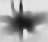
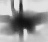
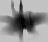
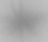
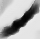
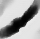
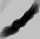
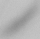
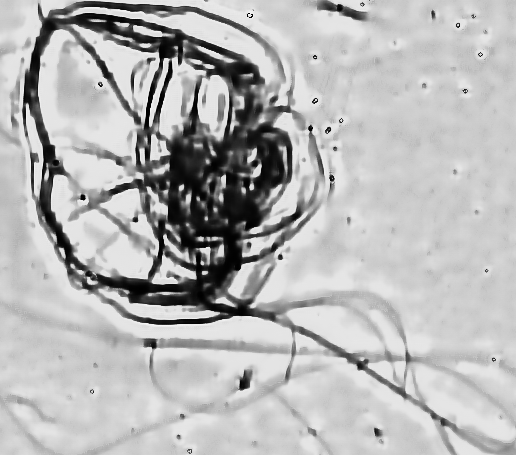
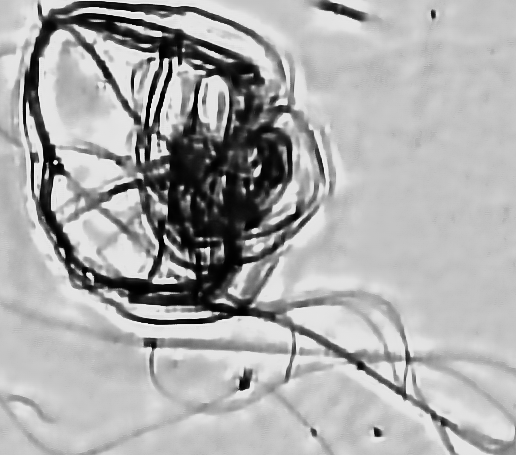
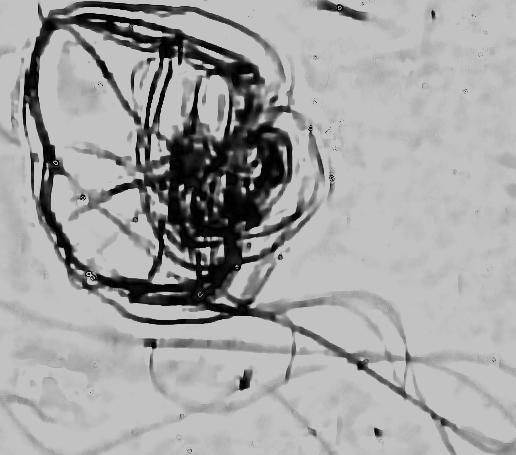
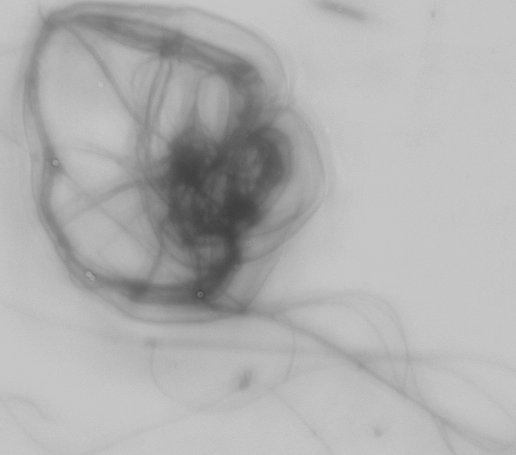
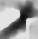
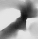
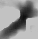
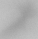
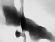
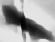
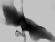
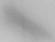
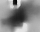
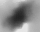
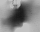
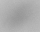
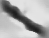
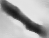
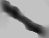
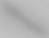
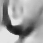
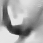
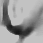
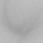
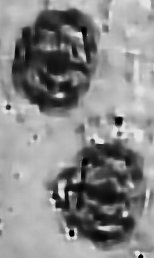
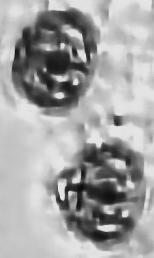
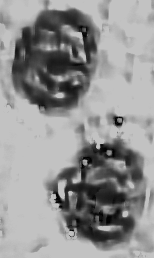
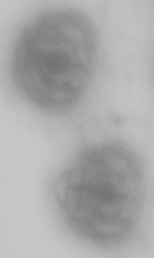
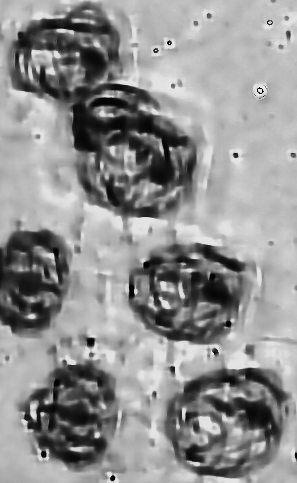
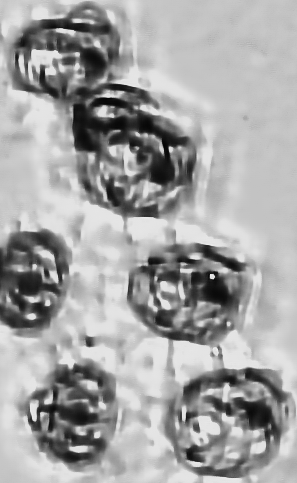
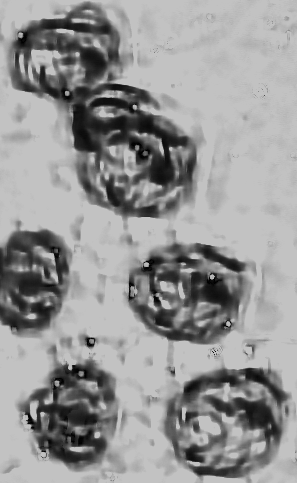
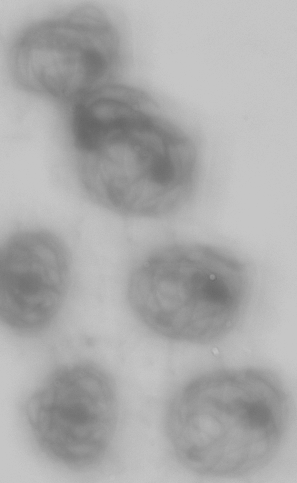

In [14]:
display_projections(
    labels=labels,
    projections=projections,
    image_paths=image_paths,
    image_data_uris=img_data_uris
)